In [1]:
# Run these on the first run
# import nltk
# nltk.download()

In [2]:
import pandas as pd
import numpy as np
import json
import os, glob

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from pprint import pprint as p

import re
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

%matplotlib inline

stop_words = stopwords.words('english')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data_dir = '16119_db21c91a1ab47385bb13773ed8238c31'
# os.listdir(data_dir)
files = [f'{data_dir}/{file}' for file in [
                '16119_webhose_2019_12_db21c91a1ab47385bb13773ed8238c31_0000001.json',
                '16119_webhose_2020_01_db21c91a1ab47385bb13773ed8238c31_0000001.json'
            ]
        ]
p(files)

['16119_db21c91a1ab47385bb13773ed8238c31/16119_webhose_2019_12_db21c91a1ab47385bb13773ed8238c31_0000001.json',
 '16119_db21c91a1ab47385bb13773ed8238c31/16119_webhose_2020_01_db21c91a1ab47385bb13773ed8238c31_0000001.json']


In [4]:
target = []
dataset = []

for file_loc in files:
    raw_file = open(file_loc)

    for f in raw_file:
        raw_obj = json.loads(f)
        target.append(raw_obj['title'])
        dataset.append(raw_obj['text'])
    raw_file.close()

len(target), len(dataset)

(94403, 94403)

In [5]:
# p(target)
# p(dataset)

In [6]:
contraction_map = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [7]:
def preprocess(text):
    text = text.lower() # lowercase
    text = text.split() # convert have'nt -> have not

    for i in range(len(text)):
        word = text[i]
        if word in contraction_map:
            text[i] = contraction_map[word]
    text = " ".join(text)
    text = text.split()
    newtext = []
    for word in text:
        if word not in stop_words:
            newtext.append(word)
    text = " ".join(newtext)
    text = text.replace("'s",'') # convert your's -> your
    text = re.sub(r'\(.*\)','',text) # remove (words)
    text = re.sub(r'[^a-zA-Z0-9. ]','',text) # remove punctuations
    text = re.sub(r'\.',' . ',text)
    return text

In [8]:
target[0], preprocess(target[0])

('Global Swine Healthcare Market by Products, Diseases & Geography – Forecast to 2024',
 'global swine healthcare market products diseases  geography  forecast 2024')

In [9]:
dataset[0], preprocess(dataset[0])

('Dublin, The “Swine Healthcare Market – Growth, Trends, and Forecast (2019 – 2024)” report has been added to ResearchAndMarkets.com’s offering.\nThe global swine health market is expected to register a healthy CAGR during the forecast period, owing to the increasing incidence of swine diseases.\nChina Ministry of Agriculture and Rural Affairs (MARA) confirmed its first African swine fever (ASF) outbreak in Liaoning Province in 2018, 145 ASF outbreaks detected in 32 Provinces/Autonomous Regions/Municipalities/Special Administrative Region. More than 1,160,000 pigs have been rising investments in R&D activities in the development of novel therapeutics, a growing number of governments initiatives for the prevention of zoonotic diseases, increasing demand for livestock products is expected to propel the global swine health market. culled in an effort to halt the further spread. Additionally, the growing consumption of pork globally.\nKey Market Trends\nVaccines are Expected to Lead the Ma

In [10]:
X = [preprocess(d) for d in dataset]
X[0]

'dublin swine healthcare market  growth trends forecast  5 . 2 . 2 coccidiosis 5 . 2 . 3 respiratory diseases 5 . 2 . 4 swine dysentery 5 . 2 . 5 porcine parvovirus 5 . 2 . 6 others 5 . 3 geography 5 . 3 . 1 north america 5 . 3 . 2 europe 5 . 3 . 3 asiapacific 5 . 3 . 4 middle east  africa 5 . 3 . 5 south america 6 competitive landscape 6 . 1 company profiles 6 . 1 . 1 abaxis 6 . 1 . 2 bayer animal health 6 . 1 . 3 boehringer ingelheim 6 . 1 . 4 ceva animal health inc .  6 . 1 . 5 elanco 6 . 1 . 6 idvet 6 . 1 . 7 merck animal health 6 . 1 . 8 merial 6 . 1 . 9 vetoquinol s . a .  6 . 1 . 10 virbac 6 . 1 . 11 zoetis animal healthcare 7 market opportunities future trends information report visit httpswww . researchandmarkets . comrshhuje research markets also offers custom research services providing focused comprehensive tailored research .  contact researchandmarkets . com laura wood senior press manager pressresearchandmarkets . com e . s . t office hours call 19173000470 u . s . can t

In [11]:
Y = [preprocess(t) for t in target]
Y[0]

'global swine healthcare market products diseases  geography  forecast 2024'

In [12]:
len(X), len(Y)

(94403, 94403)

(array([2.2938e+04, 1.7505e+04, 1.5652e+04, 1.1503e+04, 8.5890e+03,
        5.4710e+03, 4.0500e+03, 2.8580e+03, 1.9940e+03, 1.3700e+03,
        8.8100e+02, 5.3800e+02, 2.9500e+02, 1.9600e+02, 1.4000e+02,
        9.0000e+01, 6.3000e+01, 3.8000e+01, 2.6000e+01, 6.3000e+01,
        1.9000e+01, 2.4000e+01, 1.3000e+01, 5.0000e+00, 5.0000e+00,
        8.0000e+00, 4.0000e+00, 5.0000e+00, 3.0000e+00, 1.0000e+00,
        3.0000e+00, 3.0000e+00, 2.0000e+00, 6.0000e+00, 1.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00,
        1.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.00

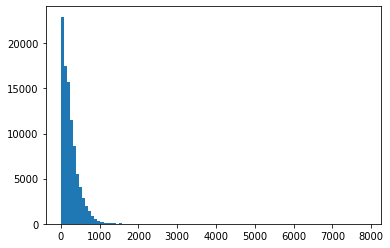

In [13]:
plt.hist([len(x.split()) for x in X], bins=100)

(array([4.893e+03, 5.169e+03, 4.494e+03, 3.729e+03, 3.626e+03, 3.749e+03,
        3.526e+03, 3.271e+03, 3.238e+03, 3.226e+03, 3.283e+03, 3.088e+03,
        3.096e+03, 2.896e+03, 2.843e+03, 2.648e+03, 2.501e+03, 2.222e+03,
        2.131e+03, 2.017e+03, 2.069e+03, 1.843e+03, 1.616e+03, 1.667e+03,
        1.639e+03, 1.456e+03, 1.204e+03, 1.115e+03, 1.175e+03, 1.020e+03,
        8.640e+02, 9.930e+02, 8.530e+02, 7.300e+02, 6.950e+02, 6.330e+02,
        6.900e+02, 5.890e+02, 5.500e+02, 5.960e+02, 5.490e+02, 4.200e+02,
        3.940e+02, 3.790e+02, 3.850e+02, 3.890e+02, 3.660e+02, 3.040e+02,
        2.510e+02, 2.740e+02, 2.940e+02, 2.090e+02, 1.570e+02, 1.850e+02,
        1.680e+02, 1.560e+02, 1.870e+02, 1.350e+02, 1.390e+02, 1.330e+02,
        7.400e+01, 1.010e+02, 6.800e+01, 7.100e+01, 7.500e+01, 4.900e+01,
        3.700e+01, 4.800e+01, 3.900e+01, 4.900e+01, 4.400e+01, 3.300e+01,
        2.300e+01, 2.800e+01, 4.000e+01, 2.100e+01, 2.000e+01, 3.700e+01,
        2.600e+01, 1.900e+01, 1.900e+0

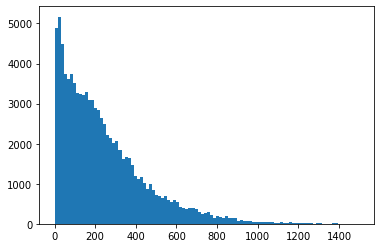

In [14]:
plt.hist([len(x.split()) for x in X if len(x.split()) < 1500], bins=100)

(array([2.3440e+03, 1.2300e+02, 7.5400e+02, 1.2260e+03, 3.4320e+03,
        7.0640e+03, 1.0769e+04, 1.5015e+04, 1.4989e+04, 1.2641e+04,
        8.9710e+03, 6.3110e+03, 4.0900e+03, 2.6300e+03, 1.6470e+03,
        9.6300e+02, 5.2600e+02, 3.5700e+02, 2.0100e+02, 1.1900e+02,
        7.0000e+01, 4.8000e+01, 2.5000e+01, 1.9000e+01, 1.4000e+01,
        1.5000e+01, 1.3000e+01, 3.0000e+00, 6.0000e+00, 2.0000e+00]),
 array([ 0.        ,  0.96666667,  1.93333333,  2.9       ,  3.86666667,
         4.83333333,  5.8       ,  6.76666667,  7.73333333,  8.7       ,
         9.66666667, 10.63333333, 11.6       , 12.56666667, 13.53333333,
        14.5       , 15.46666667, 16.43333333, 17.4       , 18.36666667,
        19.33333333, 20.3       , 21.26666667, 22.23333333, 23.2       ,
        24.16666667, 25.13333333, 26.1       , 27.06666667, 28.03333333,
        29.        ]),
 <BarContainer object of 30 artists>)

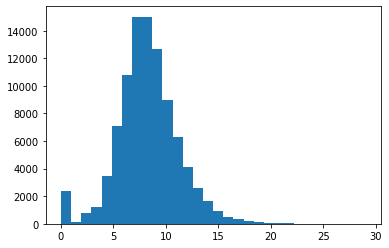

In [15]:
plt.hist([len(x.split()) for x in Y if len(x.split()) < 30], bins=30)

In [16]:
max_len_target = 30
max_len_text = 600

short_text = []
short_summary = []

for i in range(len(dataset)):
    if(len(target[i].split()) <= max_len_target and len(dataset[i].split()) <= max_len_text):
        short_text.append(dataset[i])
        short_summary.append(target[i])

temp_df = pd.DataFrame({'text': short_text, 'summary': short_summary})
temp_df.head()

,text,summary
0,FDA launches app for health care professionals...,FDA launches app for health care professionals...
1,"Of all of Regina Yan ’s many traits, an open m...",C-Suite Awards: Regina Yan
2,The CURE ID app allows clinicians to share and...,FDA Launches Infectious Disease Crowdsourcing ...
3,The DSB is composed of representatives from tw...,Drug Safety Oversight Board
4,The Centre for Health Protection (CHP) of the ...,Suspected MERS case reported


In [17]:
newdf = temp_df[temp_df['summary'].str.strip().astype(bool)]
df = newdf[newdf['text'].str.strip().astype(bool)]
df

,text,summary
0,FDA launches app for health care professionals...,FDA launches app for health care professionals...
1,"Of all of Regina Yan ’s many traits, an open m...",C-Suite Awards: Regina Yan
2,The CURE ID app allows clinicians to share and...,FDA Launches Infectious Disease Crowdsourcing ...
3,The DSB is composed of representatives from tw...,Drug Safety Oversight Board
4,The Centre for Health Protection (CHP) of the ...,Suspected MERS case reported
...,...,...
64888,A broken down train caused transport &apos;cha...,Manor House fire alert: Passengers left 'choki...
64889,Associated Press Sen. Lisa Murkowski President...,Senate close to rejecting Trump impeachment tr...
64890,Swiss player Blerim Dzemaili leaves Bologna to...,Ex-Galatasaray midfielder Dzemaili moves to China
64891,News\nThe mysterious new type of coronavirus h...,"Coronavirus has now infected almost 10,000, in..."


In [18]:
# src: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [19]:
def readData(text, summary):
    print("Reading lines...")

    # Split every line into pairs and normalize
    pairs = [[text[i],summary[i]] for i in range(len(text))]

    input_lang = Lang(text)
    output_lang = Lang(summary)

    return input_lang, output_lang, pairs

def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readData(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    return input_lang, output_lang, pairs

In [20]:
input, output, pairs = prepareData(X,Y)
pairs[0]

Reading lines...
Read 94403 sentence pairs
Counting words...


['dublin swine healthcare market  growth trends forecast  5 . 2 . 2 coccidiosis 5 . 2 . 3 respiratory diseases 5 . 2 . 4 swine dysentery 5 . 2 . 5 porcine parvovirus 5 . 2 . 6 others 5 . 3 geography 5 . 3 . 1 north america 5 . 3 . 2 europe 5 . 3 . 3 asiapacific 5 . 3 . 4 middle east  africa 5 . 3 . 5 south america 6 competitive landscape 6 . 1 company profiles 6 . 1 . 1 abaxis 6 . 1 . 2 bayer animal health 6 . 1 . 3 boehringer ingelheim 6 . 1 . 4 ceva animal health inc .  6 . 1 . 5 elanco 6 . 1 . 6 idvet 6 . 1 . 7 merck animal health 6 . 1 . 8 merial 6 . 1 . 9 vetoquinol s . a .  6 . 1 . 10 virbac 6 . 1 . 11 zoetis animal healthcare 7 market opportunities future trends information report visit httpswww . researchandmarkets . comrshhuje research markets also offers custom research services providing focused comprehensive tailored research .  contact researchandmarkets . com laura wood senior press manager pressresearchandmarkets . com e . s . t office hours call 19173000470 u . s . can 